In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
from torch.utils.data import DataLoader, random_split

# Transformations for training and validation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])

# Load the datasets
full_trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                              download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform_test)

# Split the training set into training and validation sets
train_size = int(0.9 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

# Define the data loaders
trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=100,
                       shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=100,
                        shuffle=False, num_workers=2)

100%|██████████| 169M/169M [00:04<00:00, 40.4MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
from torchvision.models import vgg16

# Load the pre-trained VGG-16 model
teacher_model = vgg16(pretrained=True)

# Adjust the classifier to output 100 classes
num_features = teacher_model.classifier[6].in_features
teacher_model.classifier[6] = nn.Linear(num_features, 100)

# Move the model to the device
teacher_model = teacher_model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 66.3MB/s]


In [4]:
def train_teacher(model, trainloader, valloader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)

        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in valloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(valloader)
        val_losses.append(val_loss)
        val_accuracy = 100. * correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n')

    return train_losses, val_losses, val_accuracies


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer_teacher = optim.SGD(teacher_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

num_epochs_teacher = 5  # Adjust as needed
teacher_train_losses, teacher_val_losses, teacher_val_accuracies = train_teacher(
    teacher_model, trainloader, valloader, criterion, optimizer_teacher, num_epochs_teacher, device)

teacher_model.eval()

Epoch [1/5]
Train Loss: 2.8464
Validation Loss: 2.0999, Validation Accuracy: 42.70%

Epoch [2/5]
Train Loss: 1.9864
Validation Loss: 1.9228, Validation Accuracy: 47.54%

Epoch [3/5]
Train Loss: 1.7186
Validation Loss: 1.6600, Validation Accuracy: 54.08%

Epoch [4/5]
Train Loss: 1.5385
Validation Loss: 1.6272, Validation Accuracy: 55.38%

Epoch [5/5]
Train Loss: 1.4261
Validation Loss: 1.5875, Validation Accuracy: 56.74%



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
from torchvision.models import vgg11

# Load the pre-trained VGG-11 model
student_model_base = vgg11(pretrained=True)

# Adjust the classifier to output 100 classes
num_features = student_model_base.classifier[6].in_features
student_model_base.classifier[6] = nn.Linear(num_features, 100)

def train_student(model, teacher_model, trainloader, valloader, criterion, optimizer, num_epochs, device, method, **kwargs):
    train_losses = []
    val_losses = []
    val_accuracies = []
    teacher_model.eval()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            if method == 'logit_matching':
                # Implement Logit Matching
                pass  # Will define later
            elif method == 'label_smoothing':
                # Implement Label Smoothing
                pass  # Will define later
            elif method == 'dkd':
                # Implement Decoupled Knowledge Distillation
                pass  # Will define later

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)

        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in valloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(valloader)
        val_losses.append(val_loss)
        val_accuracy = 100. * correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n')

    return train_losses, val_losses, val_accuracies

def evaluate(model, dataloader, device):
    model.eval()
    total = 0
    correct = 0
    losses = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            losses += loss.item()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = losses / len(dataloader)
    accuracy = 100. * correct / total
    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:03<00:00, 161MB/s]


In [7]:
def train_logit_matching(model, teacher_model, trainloader, valloader, optimizer, num_epochs, device, temperature=4.0, alpha=0.1, beta=0.9):
    train_losses = []
    val_losses = []
    val_accuracies = []
    teacher_model.eval()

    criterion_ce = nn.CrossEntropyLoss()
    criterion_kd = nn.KLDivLoss(reduction='batchmean')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)

            # Compute losses
            loss_ce = criterion_ce(outputs, targets)
            loss_kd = criterion_kd(
                F.log_softmax(outputs / temperature, dim=1),
                F.softmax(teacher_outputs / temperature, dim=1)
            ) * (temperature ** 2)

            loss = alpha * loss_ce + beta * loss_kd

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)

        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in valloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion_ce(outputs, targets)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(valloader)
        val_losses.append(val_loss)
        val_accuracy = 100. * correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n')

    return train_losses, val_losses, val_accuracies

def train_label_smoothing(model, trainloader, valloader, optimizer, num_epochs, device, epsilon=0.1):
    train_losses = []
    val_losses = []
    val_accuracies = []

    num_classes = 100

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Apply label smoothing
            log_probs = F.log_softmax(outputs, dim=1)
            targets_one_hot = torch.zeros_like(outputs).scatter_(1, targets.view(-1,1), 1)
            targets_smooth = targets_one_hot * (1 - epsilon) + epsilon / num_classes

            loss = (-targets_smooth * log_probs).sum(dim=1).mean()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)

        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in valloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                log_probs = F.log_softmax(outputs, dim=1)
                targets_one_hot = torch.zeros_like(outputs).scatter_(1, targets.view(-1,1), 1)
                targets_smooth = targets_one_hot * (1 - epsilon) + epsilon / num_classes
                loss = (-targets_smooth * log_probs).sum(dim=1).mean()
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(valloader)
        val_losses.append(val_loss)
        val_accuracy = 100. * correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n')

    return train_losses, val_losses, val_accuracies



In [8]:
num_epochs = 5  # Adjust as needed
learning_rate = 0.01

# Copy the student model for training
student_model_lm = vgg11(pretrained=True)
student_model_lm.classifier[6] = nn.Linear(num_features, 100)
student_model_lm = student_model_lm.to(device)

optimizer_lm = optim.SGD(student_model_lm.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# Train the model
lm_train_losses, lm_val_losses, lm_val_accuracies = train_logit_matching(
    student_model_lm, teacher_model, trainloader, valloader, optimizer_lm, num_epochs, device)


Epoch [1/5]
Train Loss: 1.7409
Validation Loss: 2.2692, Validation Accuracy: 39.56%

Epoch [2/5]
Train Loss: 0.9762
Validation Loss: 1.9759, Validation Accuracy: 46.74%

Epoch [3/5]
Train Loss: 0.7840
Validation Loss: 1.8691, Validation Accuracy: 49.96%

Epoch [4/5]
Train Loss: 0.6906
Validation Loss: 1.7772, Validation Accuracy: 51.12%

Epoch [5/5]
Train Loss: 0.6273
Validation Loss: 1.7072, Validation Accuracy: 53.30%



In [9]:
# Copy the student model for training
student_model_lsr = vgg11(pretrained=True)
student_model_lsr.classifier[6] = nn.Linear(num_features, 100)
student_model_lsr = student_model_lsr.to(device)

optimizer_lsr = optim.SGD(student_model_lsr.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# Train the model
lsr_train_losses, lsr_val_losses, lsr_val_accuracies = train_label_smoothing(
    student_model_lsr, trainloader, valloader, optimizer_lsr, num_epochs, device)


Epoch [1/5]
Train Loss: 3.1225
Validation Loss: 2.5744, Validation Accuracy: 43.84%

Epoch [2/5]
Train Loss: 2.4900
Validation Loss: 2.3824, Validation Accuracy: 49.68%

Epoch [3/5]
Train Loss: 2.2749
Validation Loss: 2.2972, Validation Accuracy: 51.98%

Epoch [4/5]
Train Loss: 2.1234
Validation Loss: 2.1474, Validation Accuracy: 56.10%

Epoch [5/5]
Train Loss: 2.0109
Validation Loss: 2.1113, Validation Accuracy: 57.20%



In [10]:
def train_dkd(model, teacher_model, trainloader, valloader, optimizer, num_epochs, device,
              T=4.0, alpha=1.0, beta=8.0, gamma=1.0):
    train_losses = []
    val_losses = []
    val_accuracies = []
    criterion_ce = nn.CrossEntropyLoss()
    teacher_model.eval()

    for epoch in range(num_epochs):
        model.train()
        teacher_model.eval()  # Ensure teacher is in eval mode
        running_loss = 0.0

        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            # Forward pass
            student_logits = model(inputs)
            with torch.no_grad():
                teacher_logits = teacher_model(inputs)

            # Basic CE loss
            loss_ce = criterion_ce(student_logits, targets)

            # Temperature scaling for KD
            soft_student = student_logits / T
            soft_teacher = teacher_logits / T

            # Get softmax probabilities
            p_s = F.softmax(soft_student, dim=1)
            p_t = F.softmax(soft_teacher, dim=1)

            # Create target mask
            target_mask = F.one_hot(targets, student_logits.size(1)).bool()
            nontarget_mask = ~target_mask

            # TCKD: Target Class Knowledge Distillation
            # Get probabilities for target class
            pt_s = p_s[target_mask].view(inputs.size(0), -1)
            pt_t = p_t[target_mask].view(inputs.size(0), -1)

            # Get sum of probabilities for non-target classes
            pnt_s = (p_s * nontarget_mask.float()).sum(1, keepdim=True)
            pnt_t = (p_t * nontarget_mask.float()).sum(1, keepdim=True)

            # Compute TCKD loss
            tckd = F.kl_div(
                torch.log(pt_s + 1e-7),
                pt_t,
                reduction='batchmean'
            ) + F.kl_div(
                torch.log(pnt_s + 1e-7),
                pnt_t,
                reduction='batchmean'
            )

            # NCKD: Non-target Class Knowledge Distillation
            # Get distribution over non-target classes
            nontarget_student = student_logits.clone()
            nontarget_teacher = teacher_logits.clone()

            # Mask out target class logits
            nontarget_student[target_mask] = float('-inf')
            nontarget_teacher[target_mask] = float('-inf')

            # Compute softmax over non-target classes
            p_nct_s = F.softmax(nontarget_student / T, dim=1)
            p_nct_t = F.softmax(nontarget_teacher / T, dim=1)

            # Compute NCKD loss
            nckd = F.kl_div(
                torch.log(p_nct_s + 1e-7),
                p_nct_t,
                reduction='batchmean'
            )

            # Combine losses
            loss = gamma * loss_ce + (alpha * tckd + beta * nckd) * (T ** 2)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in valloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion_ce(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(valloader)
        val_losses.append(val_loss)
        val_accuracy = 100. * correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n')

    return train_losses, val_losses, val_accuracies

# Copy the student model for training
student_model_dkd = vgg11(pretrained=True)
student_model_dkd.classifier[6] = nn.Linear(num_features, 100)
student_model_dkd = student_model_dkd.to(device)

optimizer_dkd = optim.SGD(student_model_dkd.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

T = 4.0  # Temperature
alpha = 1.0  # TCKD weight
beta = 8.0  # NCKD weight
gamma = 1.0  # CE loss weight

# Training
dkd_train_losses, dkd_val_losses, dkd_val_accuracies = train_dkd(student_model_dkd, teacher_model, trainloader, valloader,
                    optimizer_dkd, 5, device, T, alpha, beta, gamma)


Epoch [1/5]
Train Loss: 18.9278
Validation Loss: 3.5358, Validation Accuracy: 12.74%

Epoch [2/5]
Train Loss: 12.7537
Validation Loss: 2.8814, Validation Accuracy: 25.64%

Epoch [3/5]
Train Loss: 10.6406
Validation Loss: 2.7600, Validation Accuracy: 30.26%

Epoch [4/5]
Train Loss: 9.4485
Validation Loss: 2.5847, Validation Accuracy: 34.58%

Epoch [5/5]
Train Loss: 8.9001
Validation Loss: 2.4901, Validation Accuracy: 36.78%



In [11]:
print('Evaluating Logit Matching Model on Test Set:')
lm_test_loss, lm_test_accuracy = evaluate(student_model_lm, testloader, device)

print('\nEvaluating Label Smoothing Model on Test Set:')
lsr_test_loss, lsr_test_accuracy = evaluate(student_model_lsr, testloader, device)

print('\nEvaluating DKD Model on Test Set:')
dkd_test_loss, dkd_test_accuracy = evaluate(student_model_dkd, testloader, device)

Evaluating Logit Matching Model on Test Set:
Loss: 1.6076, Accuracy: 55.58%

Evaluating Label Smoothing Model on Test Set:
Loss: 1.5809, Accuracy: 58.22%

Evaluating DKD Model on Test Set:
Loss: 2.3520, Accuracy: 39.05%


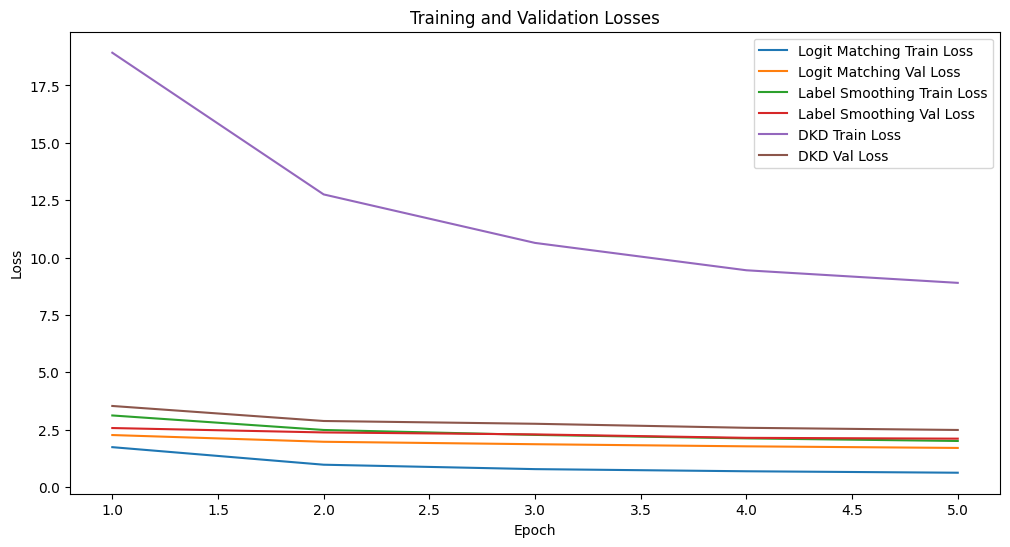

In [12]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12,6))
plt.plot(epochs, lm_train_losses, label='Logit Matching Train Loss')
plt.plot(epochs, lm_val_losses, label='Logit Matching Val Loss')
plt.plot(epochs, lsr_train_losses, label='Label Smoothing Train Loss')
plt.plot(epochs, lsr_val_losses, label='Label Smoothing Val Loss')
plt.plot(epochs, dkd_train_losses, label='DKD Train Loss')
plt.plot(epochs, dkd_val_losses, label='DKD Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

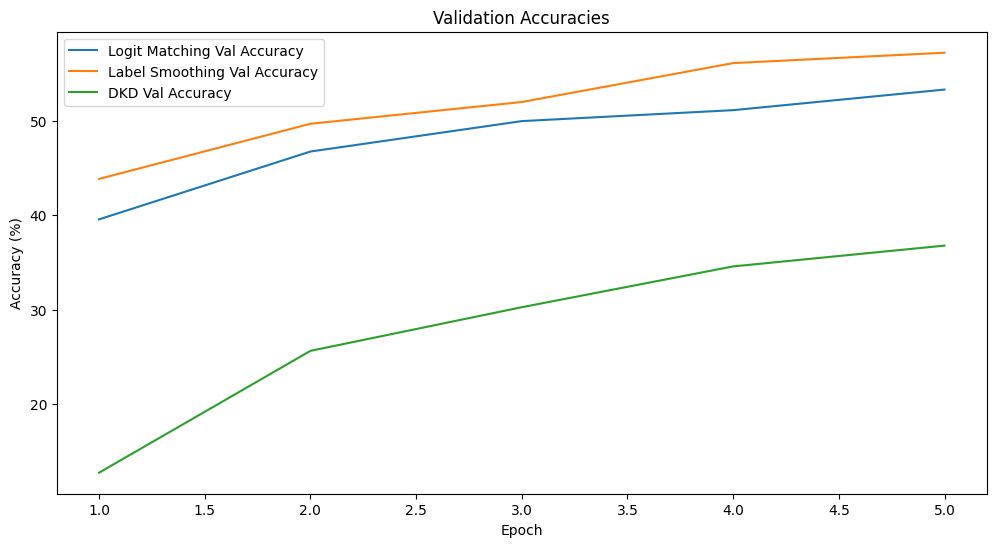

In [13]:
plt.figure(figsize=(12,6))
plt.plot(epochs, lm_val_accuracies, label='Logit Matching Val Accuracy')
plt.plot(epochs, lsr_val_accuracies, label='Label Smoothing Val Accuracy')
plt.plot(epochs, dkd_val_accuracies, label='DKD Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracies')
plt.legend()
plt.show()

In [14]:
print('\nEvaluating Teacher Model on Test Set:')
teacher_test_loss, teacher_test_accuracy = evaluate(teacher_model, testloader, device)


Evaluating Teacher Model on Test Set:
Loss: 1.5036, Accuracy: 58.23%


In [15]:
# Load the student model
student_model_si = vgg11(pretrained=True)
student_model_si.classifier[6] = nn.Linear(num_features, 100)
student_model_si = student_model_si.to(device)

# Define loss function and optimizer
criterion_si = nn.CrossEntropyLoss()
optimizer_si = optim.SGD(student_model_si.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# Training function
def train_independent_student(model, trainloader, valloader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)

        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in valloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(valloader)
        val_losses.append(val_loss)
        val_accuracy = 100. * correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n')

    return train_losses, val_losses, val_accuracies

# Train the independent student
num_epochs = 5
si_train_losses, si_val_losses, si_val_accuracies = train_independent_student(
    student_model_si, trainloader, valloader, criterion_si, optimizer_si, num_epochs, device)

print('\nEvaluating Independent Student Model on Test Set:')
si_test_loss, si_test_accuracy = evaluate(student_model_si, testloader, device)

Epoch [1/5]
Train Loss: 2.8597
Validation Loss: 2.1869, Validation Accuracy: 41.56%

Epoch [2/5]
Train Loss: 2.0621
Validation Loss: 1.9323, Validation Accuracy: 47.90%

Epoch [3/5]
Train Loss: 1.7998
Validation Loss: 1.7993, Validation Accuracy: 51.16%

Epoch [4/5]
Train Loss: 1.6106
Validation Loss: 1.7026, Validation Accuracy: 53.52%

Epoch [5/5]
Train Loss: 1.4867
Validation Loss: 1.7386, Validation Accuracy: 53.54%


Evaluating Independent Student Model on Test Set:
Loss: 1.6345, Accuracy: 55.84%


In [ ]:
# Save the finetuned teacher model
torch.save(student_model_si.state_dict(), 's_i_model.pth')

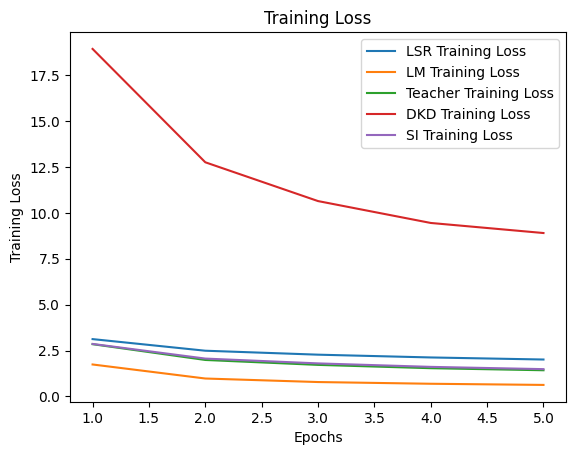

In [16]:
# Training Losses
plt.figure()
plt.plot(epochs, lsr_train_losses, label='LSR Training Loss')
plt.plot(epochs, lm_train_losses, label='LM Training Loss')
plt.plot(epochs, teacher_train_losses, label='Teacher Training Loss')
plt.plot(epochs, dkd_train_losses, label='DKD Training Loss')
plt.plot(epochs, si_train_losses, label='SI Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

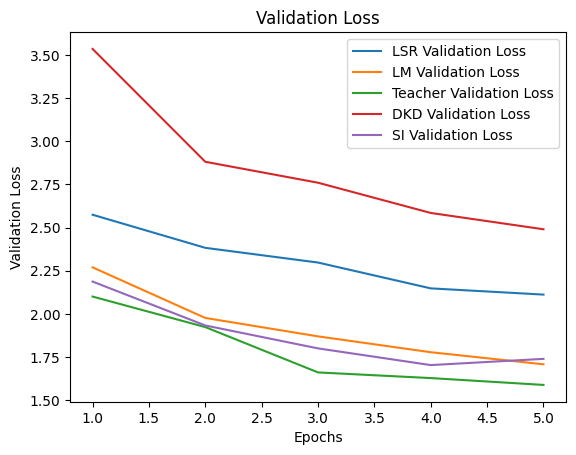

In [17]:
# Validation Losses
plt.figure()
plt.plot(epochs, lsr_val_losses, label='LSR Validation Loss')
plt.plot(epochs, lm_val_losses, label='LM Validation Loss')
plt.plot(epochs, teacher_val_losses, label='Teacher Validation Loss')
plt.plot(epochs, dkd_val_losses, label='DKD Validation Loss')
plt.plot(epochs, si_val_losses, label='SI Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

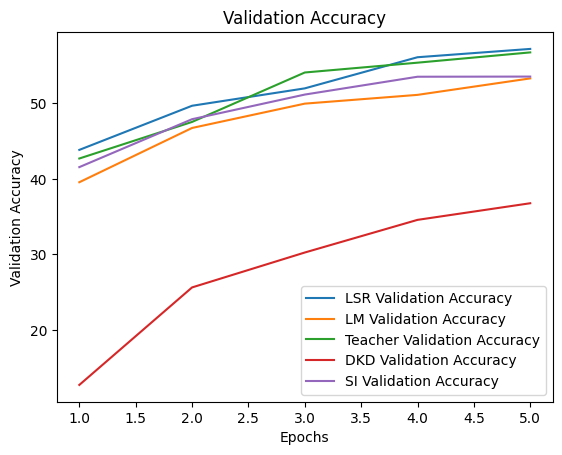

In [18]:
# Validation Accuracies
plt.figure()
plt.plot(epochs, lsr_val_accuracies, label='LSR Validation Accuracy')
plt.plot(epochs, lm_val_accuracies, label='LM Validation Accuracy')
plt.plot(epochs, teacher_val_accuracies, label='Teacher Validation Accuracy')
plt.plot(epochs, dkd_val_accuracies, label='DKD Validation Accuracy')
plt.plot(epochs, si_val_accuracies, label='SI Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

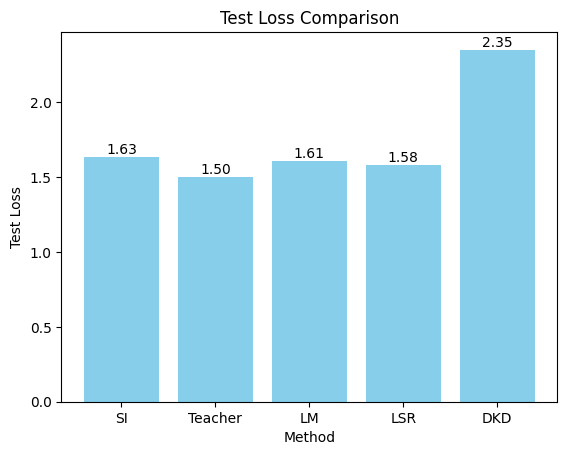

In [19]:
# Test Loss Comparison
methods = ['SI', 'Teacher', 'LM', 'LSR', 'DKD']
test_losses = [si_test_loss, teacher_test_loss, lm_test_loss, lsr_test_loss, dkd_test_loss]

plt.figure()
bars = plt.bar(methods, test_losses, color='skyblue')
plt.xlabel('Method')
plt.ylabel('Test Loss')
plt.title('Test Loss Comparison')

# Add the exact value above each bar
for bar, loss in zip(bars, test_losses):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{loss:.2f}',
             ha='center', va='bottom', fontsize=10)

plt.show()

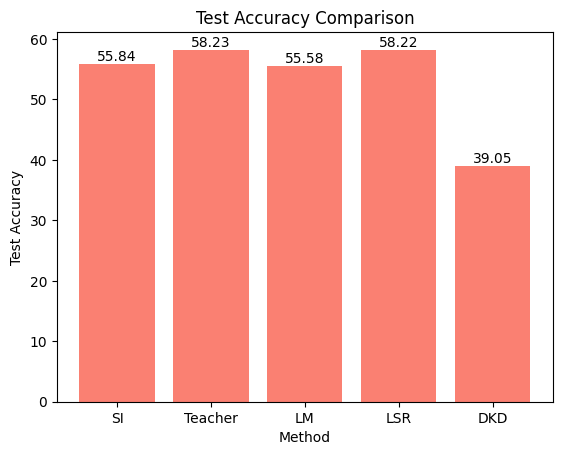

In [20]:
# Test Accuracy Comparison
test_accuracies = [si_test_accuracy, teacher_test_accuracy, lm_test_accuracy, lsr_test_accuracy, dkd_test_accuracy]
methods = ['SI', 'Teacher', 'LM', 'LSR', 'DKD']

plt.figure()
bars = plt.bar(methods, test_accuracies, color='salmon')
plt.xlabel('Method')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')

# Add the exact value above each bar
for bar, accuracy in zip(bars, test_accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{accuracy:.2f}',
             ha='center', va='bottom', fontsize=10)

plt.show()

In [21]:
teacher_model.eval()

student_model = vgg11(pretrained=True)
# Adjust the classifier to match the new input size
student_model.classifier = nn.Linear(512, 100)
student_model = student_model.to(device)

class StudentWithRegressor(nn.Module):
    def __init__(self, student):
        super(StudentWithRegressor, self).__init__()

        # Select layers up to the guided layer
        self.features = nn.Sequential(*list(student.features.children())[:6])  # Up to MaxPool after Conv128

        # Remaining layers from the student
        self.remaining_layers = nn.Sequential(*list(student.features.children())[6:])

        # Regressor: 128 channels (from guided layer) -> 256 channels (to match teacher's hint layer)
        self.regressor = nn.Conv2d(128, 256, kernel_size=1)

        # Add AdaptiveAvgPool to ensure consistent spatial dimensions
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Adjusted classifier to match the new input size
        self.classifier = nn.Linear(512, 100)  # 512 channels from last conv layer, 100 classes for CIFAR-100

    def forward(self, x):
        # Forward through guided layers
        guided_output = self.features(x)  # Shape: [batch_size, 128, 8, 8]

        # Regressed output (for hint loss)
        regressed_output = F.relu(self.regressor(guided_output))  # Shape: [batch_size, 256, 8, 8]

        # Forward through remaining layers
        remaining_output = self.remaining_layers(guided_output)  # Shape: [batch_size, 512, 1, 1]

        # Apply AdaptiveAvgPool
        pooled_output = self.avgpool(remaining_output)  # Shape: [batch_size, 512, 1, 1]

        # Flatten the output
        out = pooled_output.view(pooled_output.size(0), -1)  # Shape: [batch_size, 512]

        # Classifier
        out = self.classifier(out)  # Shape: [batch_size, 100]

        return out, regressed_output

def test_shapes(student_with_regressor, teacher_model, device):
    # Create a dummy input
    dummy_input = torch.randn(1, 3, 32, 32).to(device)

    # Get guided layer output
    guided_output = student_with_regressor.features(dummy_input)
    print(f"\nGuided layer output shape: {guided_output.shape}")

    # Get regressed output
    _, regressed_output = student_with_regressor(dummy_input)
    print(f"Regressed output shape: {regressed_output.shape}")

    # Get teacher hint output
    with torch.no_grad():
        teacher_hint = teacher_model.features[:14](dummy_input)
    print(f"Teacher hint output shape: {teacher_hint.shape}")

    # Get remaining output
    remaining_output = student_with_regressor.remaining_layers(guided_output)
    print(f"Remaining output shape: {remaining_output.shape}")

    # After adaptive pooling
    pooled_output = student_with_regressor.avgpool(remaining_output)
    print(f"Pooled output shape: {pooled_output.shape}")

    # Flattened output
    out = pooled_output.view(pooled_output.size(0), -1)
    print(f"Flattened output shape: {out.shape}")

def train_stage1(student_model, teacher_model, trainloader, num_epochs, device):
    student_model.train()
    teacher_model.eval()

    criterion_hint = nn.MSELoss()
    optimizer = optim.SGD([
        {'params': student_model.features.parameters()},
        {'params': student_model.regressor.parameters()}
    ], lr=0.01, momentum=0.9, weight_decay=5e-4)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, _) in enumerate(trainloader):
            inputs = inputs.to(device)

            optimizer.zero_grad()

            # Forward pass through student
            _, student_regressed_output = student_model(inputs)

            # Get teacher's hint output
            with torch.no_grad():
                # Select teacher hint layer that outputs 256 channels
                teacher_hint_output = teacher_model.features[:14](inputs)  # Adjust based on desired teacher feature level

            # Print shapes on first batch of first epoch
            if epoch == 0 and i == 0:
                print(f"Student guided output shape (before regressor): {student_model.features(inputs).shape}")
                print(f"Student regressed output shape: {student_regressed_output.shape}")
                print(f"Teacher hint output shape: {teacher_hint_output.shape}")

            # Compute hint loss
            loss = criterion_hint(student_regressed_output, teacher_hint_output)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}], Loss: {running_loss/100:.4f}')
                running_loss = 0.0

        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss/len(trainloader):.4f}')

def train_stage2(student_model, teacher_model, trainloader, valloader, num_epochs, device):
    student_model.train()
    teacher_model.eval()

    criterion_ce = nn.CrossEntropyLoss()
    criterion_kd = nn.KLDivLoss(reduction='batchmean')
    optimizer = optim.SGD(student_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

    temperature = 4.0
    alpha = 0.1
    beta = 0.9

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        total = 0
        correct = 0

        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs, _ = student_model(inputs)
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)

            # Compute losses
            loss_ce = criterion_ce(outputs, targets)
            loss_kd = criterion_kd(
                F.log_softmax(outputs / temperature, dim=1),
                F.softmax(teacher_outputs / temperature, dim=1)
            ) * (temperature ** 2)

            loss = alpha * loss_ce + beta * loss_kd

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Statistics
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        train_accuracy = 100. * correct / total

        # Evaluate on validation set
        student_model.eval()
        val_loss = 0.0
        total = 0
        correct = 0

        with torch.no_grad():
            for inputs, targets in valloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs, _ = student_model(inputs)
                loss = criterion_ce(outputs, targets)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_loss /= len(valloader)
        val_losses.append(val_loss)
        val_accuracy = 100. * correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n')

        student_model.train()

    return train_losses, val_losses, val_accuracies

# Initialize the custom student model
student_with_regressor = StudentWithRegressor(student_model).to(device)

print("Testing shapes before training:")
test_shapes(student_with_regressor, teacher_model, device)

# Proceed with training stages as before
num_epochs_stage1 = 5  # Adjust as needed
train_stage1(student_with_regressor, teacher_model, trainloader, num_epochs_stage1, device)

num_epochs_stage2 = 5  # Adjust as needed
hint_train_losses, hint_val_losses, hint_val_accuracies = train_stage2(
    student_with_regressor, teacher_model, trainloader, valloader, num_epochs_stage2, device)


Testing shapes before training:

Guided layer output shape: torch.Size([1, 128, 8, 8])
Regressed output shape: torch.Size([1, 256, 8, 8])
Teacher hint output shape: torch.Size([1, 256, 8, 8])
Remaining output shape: torch.Size([1, 512, 1, 1])
Pooled output shape: torch.Size([1, 512, 1, 1])
Flattened output shape: torch.Size([1, 512])
Student guided output shape (before regressor): torch.Size([128, 128, 8, 8])
Student regressed output shape: torch.Size([128, 256, 8, 8])
Teacher hint output shape: torch.Size([128, 256, 8, 8])
Epoch [1/5], Batch [100], Loss: 1.1981
Epoch [1/5], Batch [200], Loss: 1.0781
Epoch [1/5], Batch [300], Loss: 1.0353
Epoch [1/5], Average Loss: 0.1484
Epoch [2/5], Batch [100], Loss: 0.9850
Epoch [2/5], Batch [200], Loss: 0.9497
Epoch [2/5], Batch [300], Loss: 0.9226
Epoch [2/5], Average Loss: 0.1330
Epoch [3/5], Batch [100], Loss: 0.8880
Epoch [3/5], Batch [200], Loss: 0.8778
Epoch [3/5], Batch [300], Loss: 0.8548
Epoch [3/5], Average Loss: 0.1253
Epoch [4/5], Batc

In [22]:
def evaluate_hint_model(model, testloader, device):
    model.eval()
    total = 0
    correct = 0
    losses = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, targets)
            losses += loss.item()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = losses / len(testloader)
    accuracy = 100. * correct / total
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

# Evaluate the model
hint_test_loss, hint_test_accuracy = evaluate_hint_model(student_with_regressor, testloader, device)

Test Loss: 1.6150, Test Accuracy: 54.91%


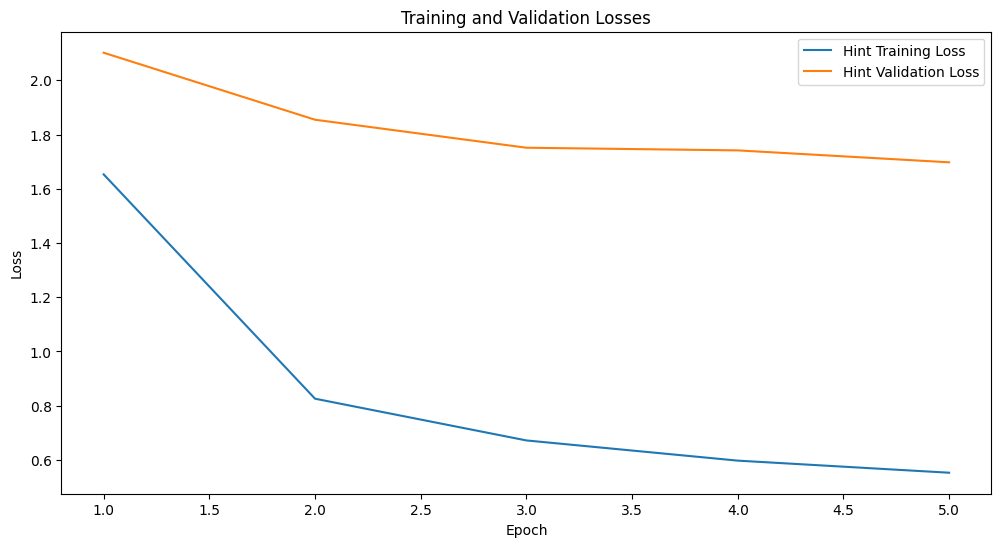

In [23]:

epochs = range(1, num_epochs_stage2 + 1)

plt.figure(figsize=(12,6))
plt.plot(epochs, hint_train_losses, label='Hint Training Loss')
plt.plot(epochs, hint_val_losses, label='Hint Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

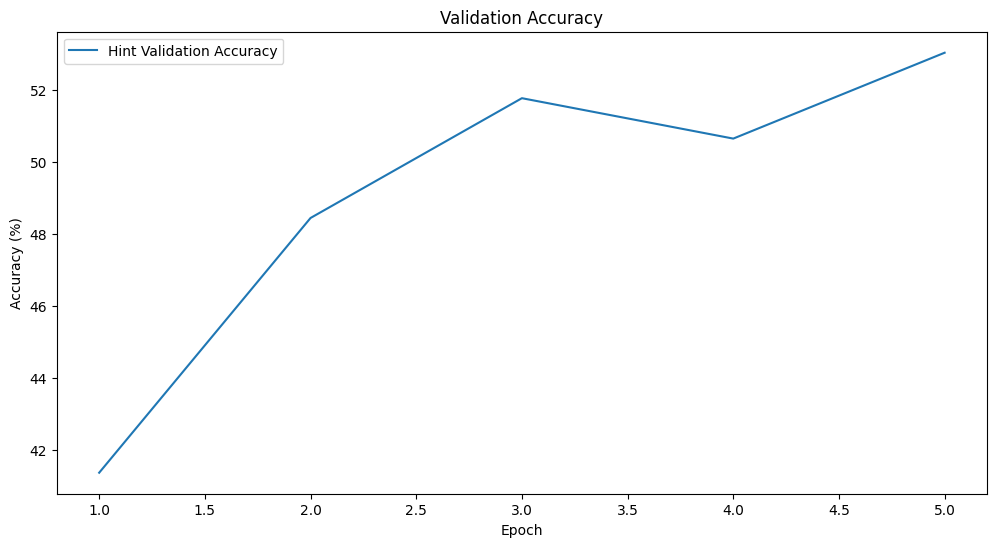

In [24]:
plt.figure(figsize=(12,6))
plt.plot(epochs, hint_val_accuracies, label='Hint Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.show()


In [25]:
# Training and Validation Losses/Accuracies
print("LSR Training Losses:", lsr_train_losses)
print("LSR Validation Losses:", lsr_val_losses)
print("LSR Validation Accuracies:", lsr_val_accuracies)

print("LM Training Losses:", lm_train_losses)
print("LM Validation Losses:", lm_val_losses)
print("LM Validation Accuracies:", lm_val_accuracies)

print("Teacher Training Losses:", teacher_train_losses)
print("Teacher Validation Losses:", teacher_val_losses)
print("Teacher Validation Accuracies:", teacher_val_accuracies)

print("DKD Training Losses:", dkd_train_losses)
print("DKD Validation Losses:", dkd_val_losses)
print("DKD Validation Accuracies:", dkd_val_accuracies)

print("SI Training Losses:", si_train_losses)
print("SI Validation Losses:", si_val_losses)
print("SI Validation Accuracies:", si_val_accuracies)

print("HINT Training Losses:", hint_train_losses)
print("HINT Validation Losses:", hint_val_losses)
print("HINT Validation Accuracies:", hint_val_accuracies)

# Test Losses and Accuracies
print("\nSI Test Loss:", si_test_loss)
print("SI Test Accuracy:", si_test_accuracy)

print("Teacher Test Loss:", teacher_test_loss)
print("Teacher Test Accuracy:", teacher_test_accuracy)

print("LM Test Loss:", lm_test_loss)
print("LM Test Accuracy:", lm_test_accuracy)

print("LSR Test Loss:", lsr_test_loss)
print("LSR Test Accuracy:", lsr_test_accuracy)

print("DKD Test Loss:", dkd_test_loss)
print("DKD Test Accuracy:", dkd_test_accuracy)

print("HINT Test Loss:", hint_test_loss)
print("HINT Test Accuracy:", hint_test_accuracy)


LSR Training Losses: [3.1224815317175607, 2.48999633775516, 2.2748562029816886, 2.1233836828984995, 2.0108685882931407]
LSR Validation Losses: [2.5743854904174803, 2.3824380588531495, 2.2971547079086303, 2.1473529648780825, 2.1113179230690005]
LSR Validation Accuracies: [43.84, 49.68, 51.98, 56.1, 57.2]
LM Training Losses: [1.7408535206182436, 0.9762329217046499, 0.7840214090591128, 0.6906445983119986, 0.6272612063383515]
LM Validation Losses: [2.2692494058609007, 1.9759065842628478, 1.869062294960022, 1.7771518516540528, 1.7071607160568236]
LM Validation Accuracies: [39.56, 46.74, 49.96, 51.12, 53.3]
Teacher Training Losses: [2.8464131687175143, 1.9864025183699348, 1.7186446084894917, 1.5385188324884935, 1.4261029921472073]
Teacher Validation Losses: [2.099898433685303, 1.9228379392623902, 1.6599740314483642, 1.6272436380386353, 1.5875337100028992]
Teacher Validation Accuracies: [42.7, 47.54, 54.08, 55.38, 56.74]
DKD Training Losses: [18.92777844721621, 12.753688695755871, 10.64061284

In [26]:
from torchvision.models import vgg11

# Load the pre-trained VGG-11 model
student_model_base = vgg11(pretrained=True)
student_model_base.classifier[6] = nn.Linear(4096, 100)
student_model_base = student_model_base.to(device)

class StudentModel(nn.Module):
    def __init__(self, base_model):
        super(StudentModel, self).__init__()
        self.features = base_model.features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))  # To match the original VGG architecture
        self.classifier = base_model.classifier  # [4096] -> [100]

    def forward(self, x, return_features=False):
        x = self.features(x)
        x = self.avgpool(x)
        features = torch.flatten(x, 1)  # Shape: [batch_size, 512*7*7]
        logits = self.classifier(features)
        if return_features:
            return logits, features  # Return both logits and features
        else:
            return logits

class TeacherModel(nn.Module):
    def __init__(self, base_model):
        super(TeacherModel, self).__init__()
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.classifier = base_model.classifier

    def forward(self, x, return_features=False):
        x = self.features(x)
        x = self.avgpool(x)
        features = torch.flatten(x, 1)
        logits = self.classifier(features)
        if return_features:
            return logits, features
        else:
            return logits

student_model_crd = StudentModel(student_model_base).to(device)
teacher_model_crd = TeacherModel(teacher_model).to(device)
teacher_model_crd.eval()

def train_crd(student_model, teacher_model, trainloader, valloader, optimizer, num_epochs, device, temperature=0.1, alpha=0.1, beta=0.9):
    criterion_ce = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        student_model.train()
        running_loss = 0.0
        total = 0
        correct = 0

        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs_s, features_s = student_model(inputs, return_features=True)
            with torch.no_grad():
                outputs_t, features_t = teacher_model(inputs, return_features=True)

            # Compute cross-entropy loss
            loss_ce = criterion_ce(outputs_s, targets)

            # Normalize features
            features_s = F.normalize(features_s, dim=1)
            features_t = F.normalize(features_t, dim=1)

            # Compute similarity matrix
            logits = torch.matmul(features_s, features_t.T) / temperature  # [batch_size, batch_size]

            # Targets are indices of the diagonal elements
            batch_size = inputs.size(0)
            labels = torch.arange(batch_size).to(device)

            # Contrastive loss (cross-entropy)
            loss_crd = criterion_ce(logits, labels)

            # Total loss
            loss = alpha * loss_ce + beta * loss_crd

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Statistics
            _, predicted = outputs_s.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        train_accuracy = 100. * correct / total

        # Evaluate on validation set
        student_model.eval()
        val_loss = 0.0
        total = 0
        correct = 0

        with torch.no_grad():
            for inputs, targets in valloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs_s = student_model(inputs)
                loss = criterion_ce(outputs_s, targets)
                val_loss += loss.item()

                _, predicted = outputs_s.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_loss /= len(valloader)
        val_losses.append(val_loss)
        val_accuracy = 100. * correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n')

    return train_losses, val_losses, val_accuracies

optimizer_crd = optim.SGD(student_model_crd.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
num_epochs = 5

crd_train_losses, crd_val_losses, crd_val_accuracies = train_crd(
    student_model_crd, teacher_model_crd, trainloader, valloader, optimizer_crd, num_epochs, device)



Epoch [1/5], Train Loss: 2.7071, Train Accuracy: 25.66%
Validation Loss: 2.1257, Validation Accuracy: 44.38%

Epoch [2/5], Train Loss: 1.8451, Train Accuracy: 44.56%
Validation Loss: 1.8634, Validation Accuracy: 50.16%

Epoch [3/5], Train Loss: 1.5759, Train Accuracy: 50.44%
Validation Loss: 1.7284, Validation Accuracy: 52.94%

Epoch [4/5], Train Loss: 1.4140, Train Accuracy: 53.77%
Validation Loss: 1.6432, Validation Accuracy: 54.84%

Epoch [5/5], Train Loss: 1.2982, Train Accuracy: 56.06%
Validation Loss: 1.5812, Validation Accuracy: 56.34%



In [27]:
def evaluate(model, testloader, device):
    model.eval()
    total = 0
    correct = 0
    losses = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            losses += loss.item()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = losses / len(testloader)
    accuracy = 100. * correct / total
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

# Evaluate the model
crd_test_loss, crd_test_accuracy = evaluate(student_model_crd, testloader, device)

Test Loss: 1.5342, Test Accuracy: 56.85%


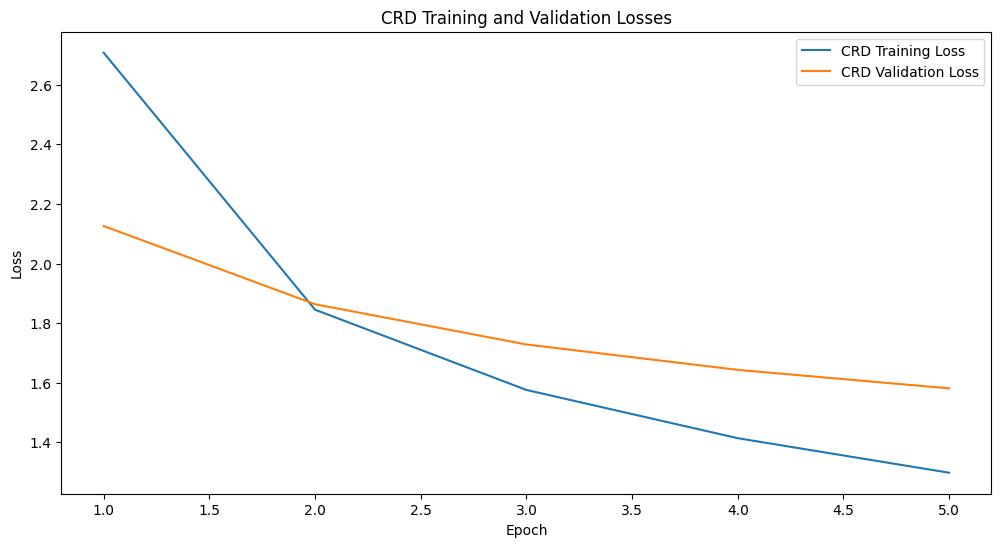

In [28]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12,6))
plt.plot(epochs, crd_train_losses, label='CRD Training Loss')
plt.plot(epochs, crd_val_losses, label='CRD Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CRD Training and Validation Losses')
plt.legend()
plt.show()


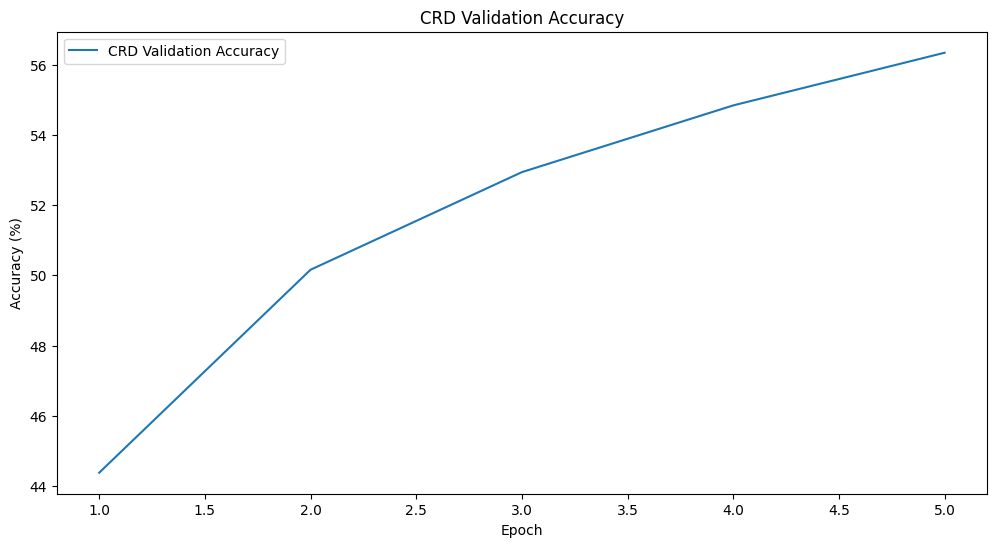

In [29]:
plt.figure(figsize=(12,6))
plt.plot(epochs, crd_val_accuracies, label='CRD Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('CRD Validation Accuracy')
plt.legend()
plt.show()


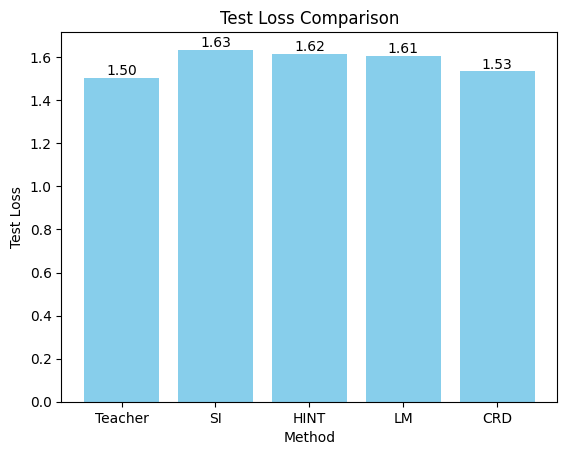

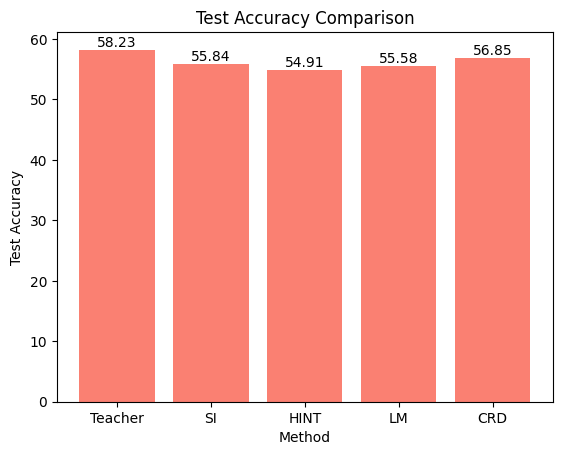

In [30]:
methods = ['Teacher', 'SI', 'HINT', 'LM', 'CRD']
test_losses = [teacher_test_loss, si_test_loss, hint_test_loss, lm_test_loss, crd_test_loss]
test_accuracies = [teacher_test_accuracy, si_test_accuracy, hint_test_accuracy, lm_test_accuracy, crd_test_accuracy]

# Test Loss Comparison
plt.figure()
bars = plt.bar(methods, test_losses, color='skyblue')
plt.xlabel('Method')
plt.ylabel('Test Loss')
plt.title('Test Loss Comparison')
for bar, loss in zip(bars, test_losses):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{loss:.2f}', ha='center', va='bottom')
plt.show()

# Test Accuracy Comparison
plt.figure()
bars = plt.bar(methods, test_accuracies, color='salmon')
plt.xlabel('Method')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')
for bar, accuracy in zip(bars, test_accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{accuracy:.2f}', ha='center', va='bottom')
plt.show()

In [31]:
# Teacher Metrics
print("Teacher Test Loss:", teacher_test_loss)
print("Teacher Test Accuracy:", teacher_test_accuracy)
print("Teacher Training Losses:", teacher_train_losses)
print("Teacher Validation Losses:", teacher_val_losses)
print("Teacher Validation Accuracies:", teacher_val_accuracies)

# SI Metrics
print("\nSI Training Losses:", si_train_losses)
print("SI Validation Losses:", si_val_losses)
print("SI Validation Accuracies:", si_val_accuracies)
print("SI Test Loss:", si_test_loss)
print("SI Test Accuracy:", si_test_accuracy)

# HINT Metrics
print("\nHINT Training Losses:", hint_train_losses)
print("HINT Validation Losses:", hint_val_losses)
print("HINT Validation Accuracies:", hint_val_accuracies)
print("HINT Test Loss:", hint_test_loss)
print("HINT Test Accuracy:", hint_test_accuracy)

# LM Metrics
print("\nLM Training Losses:", lm_train_losses)
print("LM Validation Losses:", lm_val_losses)
print("LM Validation Accuracies:", lm_val_accuracies)
print("LM Test Loss:", lm_test_loss)
print("LM Test Accuracy:", lm_test_accuracy)

# CRD Metrics
print("\nCRD Training Losses:", crd_train_losses)
print("CRD Validation Losses:", crd_val_losses)
print("CRD Validation Accuracies:", crd_val_accuracies)
print("CRD Test Loss:", crd_test_loss)
print("CRD Test Accuracy:", crd_test_accuracy)


Teacher Test Loss: 1.503634374141693
Teacher Test Accuracy: 58.23
Teacher Training Losses: [2.8464131687175143, 1.9864025183699348, 1.7186446084894917, 1.5385188324884935, 1.4261029921472073]
Teacher Validation Losses: [2.099898433685303, 1.9228379392623902, 1.6599740314483642, 1.6272436380386353, 1.5875337100028992]
Teacher Validation Accuracies: [42.7, 47.54, 54.08, 55.38, 56.74]

SI Training Losses: [2.859682306308638, 2.062109163877639, 1.79976786673069, 1.6105927286500281, 1.4867391102015972]
SI Validation Losses: [2.1868788051605224, 1.9323301529884338, 1.7993483138084412, 1.7025557708740235, 1.7386137557029724]
SI Validation Accuracies: [41.56, 47.9, 51.16, 53.52, 53.54]
SI Test Loss: 1.6345417165756226
SI Test Accuracy: 55.84

HINT Training Losses: [1.6530442093922333, 0.8259187123992227, 0.6719921444627371, 0.5975223505361513, 0.5529464244503867]
HINT Validation Losses: [2.1017392587661745, 1.854647581577301, 1.7514035201072693, 1.741592791080475, 1.6976167106628417]
HINT Vali

In [ ]:
torch.save(student_model_lm.state_dict(), 'logit_matching_student.pth')
torch.save(student_model_crd.state_dict(), 'crd_student.pth')
torch.save(student_with_regressor.state_dict(), 'hint_student.pth')

task 3.3

In [32]:
from torch.utils.data import DataLoader, Subset

# Define the transformations
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])

# Load the test set
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform_test)

# Define a subset of the test set as query images
query_indices = np.random.choice(len(testset), size=5000, replace=False)  # Use 5000 images
queryset = Subset(testset, query_indices)
queryloader = DataLoader(queryset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified


In [33]:
teacher_model.eval()
student_model_lm.eval()
student_model_crd.eval()
student_with_regressor.eval()
student_model_si.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [36]:
import torch.nn.functional as F

def compute_average_kl_divergence(teacher_model, student_model, dataloader, device, temperature):
    teacher_model.eval()
    student_model.eval()

    total_kl_div = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)

            # Get teacher outputs
            teacher_outputs = teacher_model(inputs)
            if isinstance(teacher_outputs, tuple):
                teacher_outputs = teacher_outputs[0]

            # Get student outputs
            student_outputs = student_model(inputs)
            if isinstance(student_outputs, tuple):
                student_outputs = student_outputs[0]

            # Apply temperature scaling
            teacher_logits = teacher_outputs / temperature
            student_logits = student_outputs / temperature

            # Compute softmax probabilities
            teacher_probs = F.softmax(teacher_logits, dim=1)
            student_log_probs = F.log_softmax(student_logits, dim=1)

            # Compute KL divergence for the batch
            kl_div = F.kl_div(student_log_probs, teacher_probs, reduction='batchmean')

            batch_size = inputs.size(0)
            total_kl_div += kl_div.item() * batch_size
            total_samples += batch_size

    average_kl_div = total_kl_div / total_samples
    return average_kl_div


In [37]:
temperature = 4.0  # Same as used during training

kl_div_lm = compute_average_kl_divergence(teacher_model, student_model_lm, queryloader, device, temperature)
print(f'Average KL Divergence (Teacher vs. Logit Matching Student): {kl_div_lm:.6f}')

kl_div_hint = compute_average_kl_divergence(teacher_model, student_with_regressor, queryloader, device, temperature)
print(f'Average KL Divergence (Teacher vs. Hints Student): {kl_div_hint:.6f}')

kl_div_crd = compute_average_kl_divergence(teacher_model, student_model_crd, queryloader, device, temperature)
print(f'Average KL Divergence (Teacher vs. CRD Student): {kl_div_crd:.6f}')

kl_div_si = compute_average_kl_divergence(teacher_model, student_model_si, queryloader, device, temperature)
print(f'Average KL Divergence (Teacher vs. Independent Student): {kl_div_si:.6f}')


Average KL Divergence (Teacher vs. Logit Matching Student): 0.027115
Average KL Divergence (Teacher vs. Hints Student): 0.028792
Average KL Divergence (Teacher vs. CRD Student): 0.065351
Average KL Divergence (Teacher vs. Independent Student): 0.101211


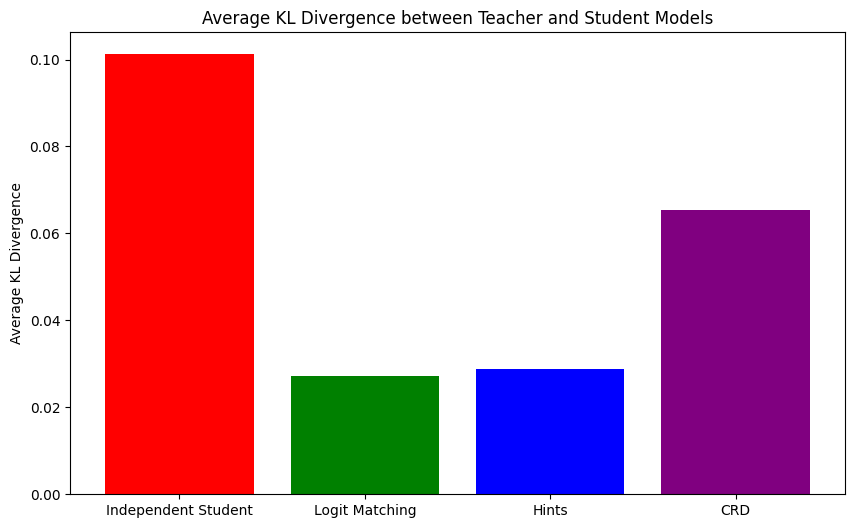

In [38]:
models = ['Independent Student', 'Logit Matching', 'Hints', 'CRD']
kl_divergences = [kl_div_si, kl_div_lm, kl_div_hint, kl_div_crd]

plt.figure(figsize=(10,6))
plt.bar(models, kl_divergences, color=['red', 'green', 'blue', 'purple'])
plt.ylabel('Average KL Divergence')
plt.title('Average KL Divergence between Teacher and Student Models')
plt.show()

task 3.4

In [53]:
import random
from torchvision.utils import make_grid
import cv2
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import torch
import torch.nn.functional as F

# Get a batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Select a subset of images (e.g., 4 images)
num_images = 4
indices = random.sample(range(images.size(0)), num_images)
query_images = images[indices]
query_labels = labels[indices]

# Visualize the selected images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize if necessary
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

grid = make_grid(query_images)
imshow(grid)

# For VGG models, the last convolutional layer is the last module in features
def get_target_layer(model):
    if isinstance(model, StudentWithRegressor):
        # For the student with regressor (Hints), we might need to adjust the layer
        return model.remaining_layers[-1]  # Last layer of remaining_layers
    elif isinstance(model, (StudentModel, TeacherModel)):
        return model.features[-1]  # Last layer in features
    else:
        return model.features[-1]

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradient = None
        self.activation = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def backward_hook(module, grad_input, grad_output):
            self.gradient = grad_output[0].detach()

        def forward_hook(module, input, output):
            self.activation = output.detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def generate_heatmap(self, input_image, target_class=None):
        # Ensure model is in eval mode
        self.model.eval()

        # Forward pass
        output = self.model(input_image)
        if isinstance(output, tuple):
            output = output[0]

        # Get prediction if target_class is not specified
        if target_class is None:
            target_class = output.argmax(dim=1)

        # Zero all existing gradients
        self.model.zero_grad()

        # Target for backprop
        one_hot = torch.zeros_like(output)
        one_hot[0][target_class] = 1

        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)

        # Get weights
        weights = F.adaptive_avg_pool2d(self.gradient, 1)

        # Generate heatmap
        cam = torch.mul(self.activation, weights).sum(dim=1, keepdim=True)

        # Apply ReLU
        cam = F.relu(cam)

        # Normalize
        if cam.max() != cam.min():
            cam = (cam - cam.min()) / (cam.max() - cam.min())

        # Convert to numpy
        cam = cam.squeeze().cpu().numpy()

        # Remove hooks
        for handle in self.hook_handles:
            handle.remove()

        return cam

def apply_gradcam(model, target_layer, input_image, device, target_class=None):
    gradcam = GradCAM(model, target_layer)
    with torch.enable_grad():  # Ensure gradients are enabled
        cam = gradcam.generate_heatmap(input_image.to(device), target_class)

    # Convert input image to numpy
    img = input_image.squeeze().cpu().detach().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = img * np.array([0.2675, 0.2565, 0.2761]) + np.array([0.5071, 0.4867, 0.4408])
    img = np.clip(img, 0, 1)

    # Resize heatmap to match image size
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))

    # Store raw heatmap
    raw_heatmap = cam.copy()

    # Convert heatmap to RGB
    heatmap_color = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    heatmap_color = heatmap_color.astype(np.float32) / 255

    # Overlay heatmap on image
    overlay = heatmap_color * 0.4 + img * 0.6
    overlay = np.clip(overlay, 0, 1)

    return overlay, raw_heatmap

def compute_similarity(h1, h2):
    # Add small epsilon to avoid division by zero
    eps = 1e-7

    # Normalize the heatmaps
    h1_norm = (h1 - h1.mean()) / (h1.std() + eps)
    h2_norm = (h2 - h2.mean()) / (h2.std() + eps)

    # Compute correlation
    correlation = np.mean(h1_norm * h2_norm)
    return correlation

# Main visualization code
def visualize_and_compare_gradcams(models, query_images, device, num_images=4):
    visualizations = {}

    for model_name, model in models.items():
        model.to(device)
        model.eval()
        vis_list = []
        heatmap_list = []

        for i in range(num_images):
            input_image = query_images[i].unsqueeze(0)
            input_image = input_image.to(device)

            # Enable gradients
            input_image.requires_grad = True

            target_layer = get_target_layer(model)
            with torch.enable_grad():
                overlay, raw_heatmap = apply_gradcam(model, target_layer, input_image, device)

            vis_list.append(overlay)
            heatmap_list.append(raw_heatmap)

        visualizations[model_name] = {'overlays': vis_list, 'heatmaps': heatmap_list}

    # Compute similarities
    similarities = {model_name: [] for model_name in models if model_name != 'Teacher'}

    for i in range(num_images):
        teacher_heatmap = visualizations['Teacher']['heatmaps'][i]
        for model_name in similarities.keys():
            student_heatmap = visualizations[model_name]['heatmaps'][i]
            similarity = compute_similarity(teacher_heatmap, student_heatmap)
            similarities[model_name].append(similarity)

    # Print average similarities
    for model_name, sim_list in similarities.items():
        avg_similarity = np.mean(sim_list)
        print(f'Average Similarity between Teacher and {model_name} GradCAM: {avg_similarity:.4f}')

    return visualizations, similarities

# Initialize your models dictionary as before
models = {
    'Teacher': teacher_model,
    'Logit Matching': student_model_lm,
    'Hints': student_with_regressor,
    'CRD': student_model_crd,
    'Independent Student': student_model_si
}

# Run the visualization and comparison
visualizations, similarities = visualize_and_compare_gradcams(
    models,
    query_images,
    device,
    num_images=4
)

Average Similarity between Teacher and Logit Matching GradCAM: -0.1559
Average Similarity between Teacher and Hints GradCAM: 0.4171
Average Similarity between Teacher and CRD GradCAM: 0.3927
Average Similarity between Teacher and Independent Student GradCAM: 0.0000


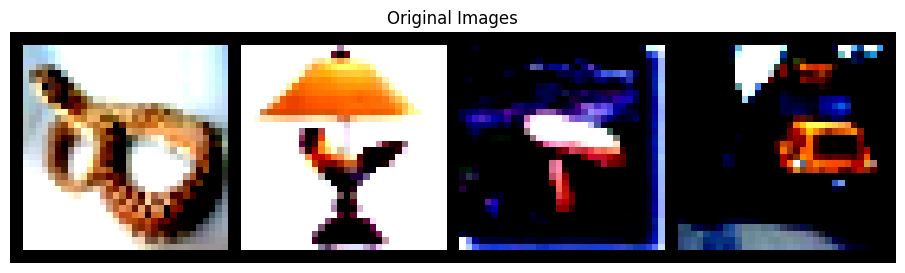

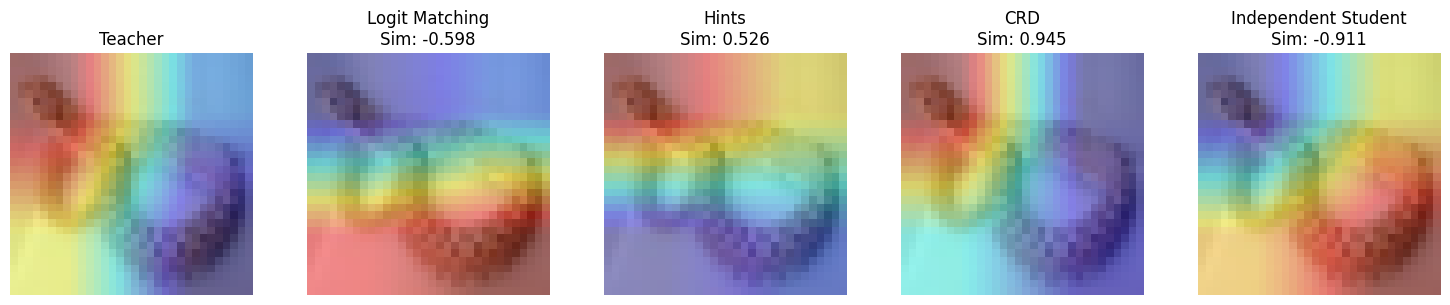

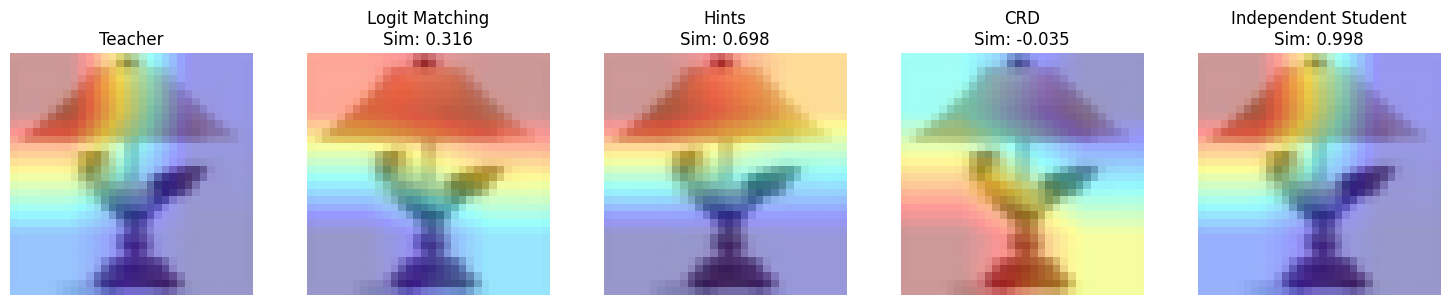

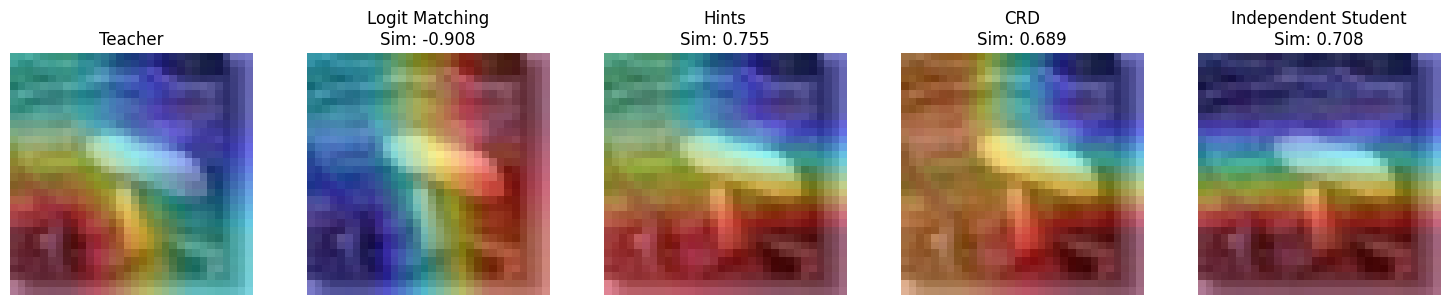

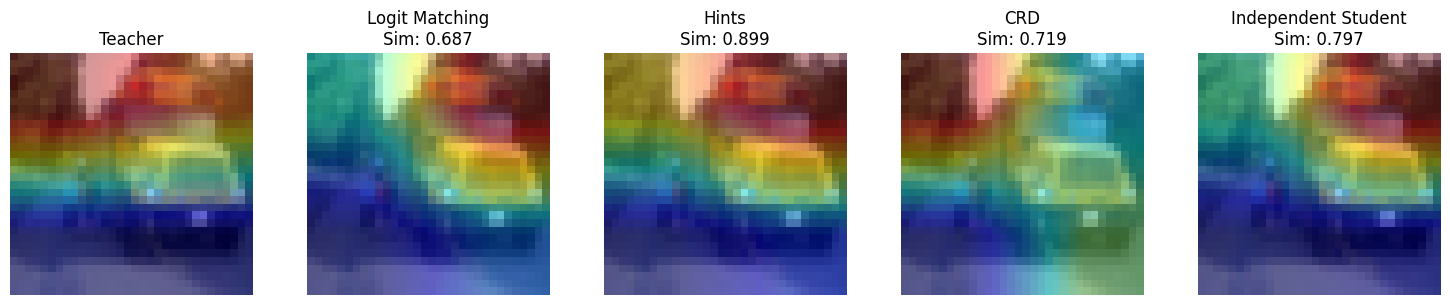


Average Similarities with Teacher:
Logit Matching: -0.1259
Hints: 0.7195
CRD: 0.5794
Independent Student: 0.3981


In [111]:
import random
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import cv2
from torchvision.utils import make_grid

def set_random_seeds(seed=42):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradient = None
        self.activation = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def backward_hook(module, grad_input, grad_output):
            self.gradient = grad_output[0].detach()

        def forward_hook(module, input, output):
            self.activation = output.detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def generate_heatmap(self, input_image, target_class=None):
        try:
            self.model.eval()
            with torch.enable_grad():
                output = self.model(input_image)
                if isinstance(output, tuple):
                    output = output[0]

                if target_class is None:
                    target_class = output.argmax(dim=1)

                self.model.zero_grad()
                one_hot = torch.zeros_like(output)
                one_hot[0][target_class] = 1
                output.backward(gradient=one_hot, retain_graph=True)

                weights = F.adaptive_avg_pool2d(self.gradient, 1)
                cam = torch.mul(self.activation, weights).sum(dim=1, keepdim=True)
                cam = F.relu(cam)

                # Improved normalization with epsilon
                eps = 1e-7
                cam = (cam - cam.min()) / (cam.max() - cam.min() + eps)

                return cam.squeeze().cpu().numpy()
        finally:
            for handle in self.hook_handles:
                handle.remove()

def apply_gradcam(model, target_layer, input_image, device, target_class=None):
    gradcam = GradCAM(model, target_layer)

    # Ensure input_image requires grad
    input_image = input_image.clone()
    input_image.requires_grad = True

    cam = gradcam.generate_heatmap(input_image.to(device), target_class)

    # Convert input image to numpy and denormalize
    img = input_image.squeeze().cpu().detach().numpy()
    img = np.transpose(img, (1, 2, 0))

    # Correct the broadcasting for normalization
    img = img * np.array([0.2675, 0.2565, 0.2761])[np.newaxis, np.newaxis, :] + np.array([0.5071, 0.4867, 0.4408])[np.newaxis, np.newaxis, :]
    img = np.clip(img, 0, 1)

    # Resize heatmap to match image size
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))
    raw_heatmap = cam_resized.copy()

    # Convert heatmap to RGB
    heatmap_color = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    heatmap_color = heatmap_color.astype(np.float32) / 255

    # Create overlay
    overlay = heatmap_color * 0.4 + img * 0.6
    overlay = np.clip(overlay, 0, 1)

    return overlay, raw_heatmap


def compute_similarity(h1, h2):
    """Compute correlation using pearsonr for more stability"""
    # Flatten and compute correlation
    correlation, _ = pearsonr(h1.flatten(), h2.flatten())
    return correlation

def visualize_and_compare_gradcams(models, query_images, device, num_images=4, seed=42):
    # Set seeds for reproducibility
    set_random_seeds(seed)

    visualizations = {}

    # Generate GradCAM visualizations
    for model_name, model in models.items():
        model.to(device)
        model.eval()
        vis_list = []
        heatmap_list = []

        for i in range(num_images):
            input_image = query_images[i].unsqueeze(0)
            target_layer = get_target_layer(model)
            overlay, raw_heatmap = apply_gradcam(model, target_layer, input_image, device)

            vis_list.append(overlay)
            heatmap_list.append(raw_heatmap)

        visualizations[model_name] = {'overlays': vis_list, 'heatmaps': heatmap_list}

    # Compute similarities
    similarities = {model_name: [] for model_name in models if model_name != 'Teacher'}

    for i in range(num_images):
        teacher_heatmap = visualizations['Teacher']['heatmaps'][i]
        for model_name in similarities.keys():
            student_heatmap = visualizations[model_name]['heatmaps'][i]
            similarity = compute_similarity(teacher_heatmap, student_heatmap)
            similarities[model_name].append(similarity)

    # Visualize the results
    for i in range(num_images):
        plt.figure(figsize=(15, 3))

        # Original image
        img = query_images[i].cpu()
        # Convert input image to numpy and denormalize
        img = img.squeeze().detach().numpy()  # Change here
        img = np.transpose(img, (1, 2, 0))
        img = np.clip(img, 0, 1)

        # Plot each model's GradCAM
        for idx, (model_name, vis_dict) in enumerate(visualizations.items()):
            plt.subplot(1, len(models), idx + 1)
            plt.imshow(vis_dict['overlays'][i])
            title = f'{model_name}'
            if model_name != 'Teacher':
                title += f'\nSim: {similarities[model_name][i]:.3f}'
            plt.title(title)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Print average similarities
    print("\nAverage Similarities with Teacher:")
    for model_name, sim_list in similarities.items():
        avg_similarity = np.mean(sim_list)
        std_similarity = np.std(sim_list)
        print(f'{model_name}: {avg_similarity:.4f}')

    return visualizations, similarities


# Example usage
def run_gradcam_analysis(testloader, models, device, num_images=4, seed=42):
    """Run complete GradCAM analysis with visualizations"""
    # Set seeds
    set_random_seeds(seed)

    # Get test images
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    # Select subset of images
    indices = random.sample(range(images.size(0)), num_images)
    query_images = images[indices]
    query_labels = labels[indices]

    # Show original images
    plt.figure(figsize=(12, 3))
    grid = make_grid(query_images)
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.title("Original Images")
    plt.axis('off')
    plt.show()

    # Run GradCAM analysis
    return visualize_and_compare_gradcams(
        models,
        query_images,
        device,
        num_images=num_images,
        seed=seed
    )

# Run the analysis
models = {
    'Teacher': teacher_model,
    'Logit Matching': student_model_lm,
    'Hints': student_with_regressor,
    'CRD': student_model_crd,
    'Independent Student': student_model_si
}

visualizations, similarities = run_gradcam_analysis(
    testloader=testloader,
    models=models,
    device=device,
    num_images=4,
    seed=42  # Set fixed seed for reproducibility
)

3.5

In [115]:
import torchvision.transforms as transforms

# Define color jitter augmentation
color_jitter = transforms.ColorJitter(
    brightness=0.4,
    contrast=0.4,
    saturation=0.4,
    hue=0.1
)

# Define transformations for training with color jitter
transform_train_color_jitter = transforms.Compose([
    color_jitter,
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])

from torch.utils.data import DataLoader

# Load the training dataset with color jitter
trainset_color_jitter = torchvision.datasets.CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=transform_train_color_jitter
)

# Define the data loader
trainloader_color_jitter = DataLoader(
    trainset_color_jitter,
    batch_size=128,
    shuffle=True,
    num_workers=2
)


Files already downloaded and verified


In [117]:
import torch.optim as optim
import torch.nn as nn

# Load the pre-trained teacher model
teacher_model_cj = vgg16(pretrained=False)
teacher_model_cj.classifier[6] = nn.Linear(4096, 100)
teacher_model_cj = teacher_model
teacher_model_cj = teacher_model_cj.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher_model_cj.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Fine-tune the model
num_epochs = 5 # You can adjust this number

for epoch in range(num_epochs):
    teacher_model_cj.train()
    running_loss = 0.0
    for inputs, targets in trainloader_color_jitter:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = teacher_model_cj(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(trainloader_color_jitter)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch [1/5], Loss: 1.5749
Epoch [2/5], Loss: 1.4717
Epoch [3/5], Loss: 1.3822
Epoch [4/5], Loss: 1.3190
Epoch [5/5], Loss: 1.2462


In [119]:
# Initialize the student model
student_model_color_invariance = student_model_si
student_model_color_invariance = student_model_color_invariance.to(device)

# Load the teacher model with color jitter
teacher_model_cj.eval()

# Wrap teacher and student models if needed (for CRD)
student_model_crd_ci = StudentModel(student_model_color_invariance).to(device)
teacher_model_crd_cj = TeacherModel(teacher_model_cj).to(device)
teacher_model_crd_cj.eval()

# Define optimizer
optimizer_crd_ci = optim.SGD(student_model_crd_ci.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Train the student model using CRD
num_epochs = 5  # Adjust as needed
train_crd(
    student_model_crd_ci,
    teacher_model_crd_cj,
    trainloader,
    valloader,
    optimizer_crd_ci,
    num_epochs,
    device
)


Epoch [1/5], Train Loss: 2.0307, Train Accuracy: 52.01%
Validation Loss: 1.7148, Validation Accuracy: 54.76%

Epoch [2/5], Train Loss: 1.1748, Train Accuracy: 58.10%
Validation Loss: 1.5561, Validation Accuracy: 57.10%

Epoch [3/5], Train Loss: 1.0043, Train Accuracy: 61.57%
Validation Loss: 1.4817, Validation Accuracy: 59.24%

Epoch [4/5], Train Loss: 0.9136, Train Accuracy: 63.78%
Validation Loss: 1.4153, Validation Accuracy: 61.26%

Epoch [5/5], Train Loss: 0.8509, Train Accuracy: 65.40%
Validation Loss: 1.3706, Validation Accuracy: 62.28%



([2.0306549373675478,
  1.1747976832769134,
  1.0042746317657558,
  0.9136006197130139,
  0.8509362488985062],
 [1.7148383593559264,
  1.5561063170433045,
  1.4817045688629151,
  1.4152567219734191,
  1.3706305980682374],
 [54.76, 57.1, 59.24, 61.26, 62.28])

In [120]:
# Define transformations for validation with color jitter
transform_val_color_jitter = transforms.Compose([
    color_jitter,
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])

# Load the validation dataset with color jitter
valset_color_jitter = torchvision.datasets.CIFAR100(
    root='./data',
    train=False,
    download=True,
    transform=transform_val_color_jitter
)

valloader_color_jitter = DataLoader(
    valset_color_jitter,
    batch_size=100,
    shuffle=False,
    num_workers=2
)

# Define evaluation function (if not already defined)
def evaluate(model, dataloader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Evaluate the student model
val_loss_ci, val_accuracy_ci = evaluate(student_model_crd_ci, valloader_color_jitter, device)
print(f'Student Model (CRD) on Color-Jittered Validation Set - Loss: {val_loss_ci:.4f}, Accuracy: {val_accuracy_ci:.2f}%')

# Evaluate the teacher model
val_loss_teacher, val_accuracy_teacher = evaluate(teacher_model_cj, valloader_color_jitter, device)
print(f'Teacher Model on Color-Jittered Validation Set - Loss: {val_loss_teacher:.4f}, Accuracy: {val_accuracy_teacher:.2f}%')


Files already downloaded and verified
Student Model (CRD) on Color-Jittered Validation Set - Loss: 1.6021, Accuracy: 57.14%
Teacher Model on Color-Jittered Validation Set - Loss: 1.4468, Accuracy: 60.94%


In [121]:
# Initialize the student model
student_model_color_invariance = vgg11(pretrained=True)
student_model_color_invariance.classifier[6] = nn.Linear(4096, 100)
student_model_color_invariance = student_model_color_invariance.to(device)

# Load the teacher model with color jitter
teacher_model_cj.eval()

# Wrap teacher and student models if needed (for CRD)
student_model_crd_ci = StudentModel(student_model_color_invariance).to(device)
teacher_model_crd_cj = TeacherModel(teacher_model_cj).to(device)
teacher_model_crd_cj.eval()

# Define optimizer
optimizer_crd_ci = optim.SGD(student_model_crd_ci.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Train the student model using CRD
num_epochs = 5  # Adjust as needed
train_crd(
    student_model_crd_ci,
    teacher_model_crd_cj,
    trainloader,
    valloader,
    optimizer_crd_ci,
    num_epochs,
    device
)

# Define transformations for validation with color jitter
transform_val_color_jitter = transforms.Compose([
    color_jitter,
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])

# Load the validation dataset with color jitter
valset_color_jitter = torchvision.datasets.CIFAR100(
    root='./data',
    train=False,
    download=True,
    transform=transform_val_color_jitter
)

valloader_color_jitter = DataLoader(
    valset_color_jitter,
    batch_size=100,
    shuffle=False,
    num_workers=2
)

# Define evaluation function (if not already defined)
def evaluate(model, dataloader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Evaluate the student model
val_loss_ci, val_accuracy_ci = evaluate(student_model_crd_ci, valloader_color_jitter, device)
print(f'Student Model (CRD) on Color-Jittered Validation Set - Loss: {val_loss_ci:.4f}, Accuracy: {val_accuracy_ci:.2f}%')

# Evaluate the teacher model
val_loss_teacher, val_accuracy_teacher = evaluate(teacher_model_cj, valloader_color_jitter, device)
print(f'Teacher Model on Color-Jittered Validation Set - Loss: {val_loss_teacher:.4f}, Accuracy: {val_accuracy_teacher:.2f}%')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Train Loss: 2.7860, Train Accuracy: 25.68%
Validation Loss: 2.1011, Validation Accuracy: 44.56%

Epoch [2/5], Train Loss: 1.8690, Train Accuracy: 45.20%
Validation Loss: 1.8243, Validation Accuracy: 51.28%

Epoch [3/5], Train Loss: 1.5949, Train Accuracy: 52.04%
Validation Loss: 1.6670, Validation Accuracy: 54.88%

Epoch [4/5], Train Loss: 1.4311, Train Accuracy: 56.01%
Validation Loss: 1.5763, Validation Accuracy: 56.48%

Epoch [5/5], Train Loss: 1.3136, Train Accuracy: 58.42%
Validation Loss: 1.5110, Validation Accuracy: 58.86%

Files already downloaded and verified
Student Model (CRD) on Color-Jittered Validation Set - Loss: 1.7114, Accuracy: 54.32%
Teacher Model on Color-Jittered Validation Set - Loss: 1.4373, Accuracy: 61.10%
